In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import punkt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from src.functions import get_sents, display_topics, unit_norm
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Read in the transcripts
raw_data_path = './data/raw/ted-talks/'
transcripts_filename = 'transcripts.csv'
t_df = pd.read_csv(raw_data_path+transcripts_filename)
# Pare down the corpus to only those talks with the word 'love'
love=t_df[t_df['transcript'].str.contains('love',case=False)]
# Tokenize
# Get the collection of n(=5)-sentence snippets with the word 'love'
love_snippets = get_sents(love,'love',0,0)

From results EDA I found that talk ID=132 and 2382 were 'outliers' after dimension reduction was performed when using CountVectorizer(binary=False).  These two talks were songs that mentioned love a lot.  By deleting them I'm trying to capture orthogonal variance in topics modeling to not be dominated by these 2 talks.

In [3]:
love_snippets.loc[[132, 2382]]

,transcript,url,n_love_sents,love
132,I’d like to dedicate this one to all the women...,https://www.ted.com/talks/vusi_mahlasela_sings...,12.0,"♫ ♫ Should I now stop singing of love, ♫ ♫ now..."
2382,(Sings) Water Boy(Guitar strum)where are you h...,https://www.ted.com/talks/rhiannon_giddens_3_s...,14.0,So I wrote a song based on some of those narra...


I'll uncomment this when I want those song talks eliminated.

In [4]:
# love_snippets.drop(labels=[132, 2382],inplace=True)

In [5]:
# Topic modeling
# Vectorize
cv1 = CountVectorizer(stop_words='english',binary=True)
cv_doc_word = cv1.fit_transform(love_snippets.love)
# Dimension Reduction
cv_lsa=[]
cv_doc_topic=[]
for i in range(2,6):
    cv_lsa.append(TruncatedSVD(i))
    cv_doc_topic.append(cv_lsa[i-2].fit_transform(cv_doc_word))
    print(int(i),'topics variance ratios:',cv_lsa[i-2].explained_variance_ratio_)

2 topics variance ratios: [0.02570641 0.01420521]
3 topics variance ratios: [0.02570641 0.01421547 0.01198931]
4 topics variance ratios: [0.02570641 0.0142091  0.01198736 0.01068457]
5 topics variance ratios: [0.02570641 0.01420989 0.01194661 0.01066725 0.01003962]


In [6]:
display_topics(cv_lsa[0], cv1.get_feature_names(), 15)


Topic  0
love, loved, people, like, just, know, think, really, time, ve, life, laughter, world, way, going

Topic  1
person, feel, loved, end, say, got, time, long, thank, life, just, years, later, thinking, way


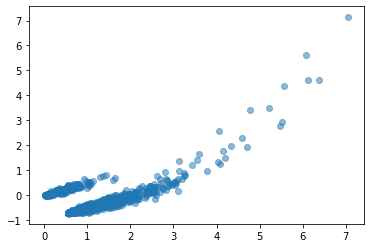

In [7]:
plt.scatter(cv_doc_topic[0][:,0],cv_doc_topic[0][:,1], alpha = 0.5);
# plt.axis([0, 60, -30, 10])

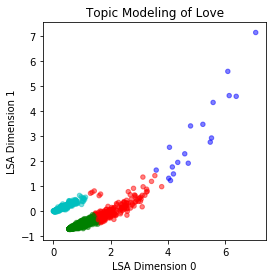

In [8]:
df=pd.DataFrame(cv_doc_topic[0],columns=['LSA Dimension 0','LSA Dimension 1'])
num_clusters = 4
km = KMeans(n_clusters=num_clusters,random_state=None,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x='LSA Dimension 0',y='LSA Dimension 1',\
                figsize=(4,4), c=col, alpha = 0.5,title='Topic Modeling of Love');
# plt.axis([-1,1.05,-1,1]);

In [9]:
for i,center in enumerate(km.cluster_centers_):
    print(cmap[i],center)

r [2.03459229 0.00491777]
g [ 0.9479017  -0.55095588]
b [4.99482495 3.06056069]
c [0.40110254 0.17654659]


In [10]:
for i,center in enumerate(km.cluster_centers_):
    clo=pd.DataFrame(cosine_similarity(X=[center],Y=cv_doc_topic[0]).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,cs in clo.iteritems():
        print(j,':',love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [2.03459229 0.00491777] color= r
233 : And so the power music has I normally compare to the power love when love doesn't see a color. You know, if you fall in love with a frog, that's it.One testimony about how I find music is powerful is when I was still a soldier back then. ♫♫ Another starving refugee ♫♫ I remember the time when I was small ♫♫ When I couldn't read or write at all ♫♫ Now I'm all grown up, I got my education ♫♫ The sky is the limit and I can't be stopped by no one ♫♫ How I prayed for this day to come ♫♫ And I pray that the world find wisdom ♫♫ To give the poor in need some assistance ♫♫ Instead of putting up resistance, yeah ♫♫ Sitting and waiting for the politics to fix this ♫♫ It ain't gonna happen ♫♫ They're all sitting on they asses ♫♫ Popping champagne and sponging off the masses ♫♫ Coming from a refugee boy-soldier ♫♫ But I still got my dignity ♫♫ I gotta say it again ♫♫ If Emma never rescued me ♫♫ I'd be a corpse on the African plain ♫Is the

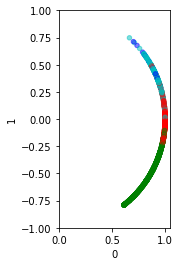

In [11]:
df = unit_norm(pd.DataFrame(cv_doc_topic[0]),demean=False)
# num_clusters = 2
# km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
# km.fit(df)
# km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

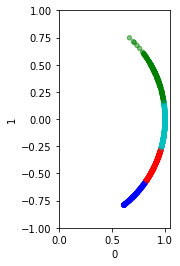

In [12]:
df = unit_norm(pd.DataFrame(cv_doc_topic[0]),demean=False)
num_clusters = 4
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

In [13]:
km.cluster_centers_

array([[ 0.89217394, -0.44092619],
       [ 0.90879503,  0.39717133],
       [ 0.70934882, -0.69950889],
       [ 0.9877101 , -0.10003431]])

In [14]:
for i, x in enumerate(km.cluster_centers_):
    print(i, x)

0 [ 0.89217394 -0.44092619]
1 [0.90879503 0.39717133]
2 [ 0.70934882 -0.69950889]
3 [ 0.9877101  -0.10003431]


In [15]:
for i,center in enumerate(km.cluster_centers_):
    clo=pd.DataFrame(cosine_similarity(X=[center],Y=cv_doc_topic[0]).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,cs in clo.iteritems():
        print(j,':',love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.89217394 -0.44092619] color= r
1109 : Although I'd love to go on about all the details of this algorithm, luckily for you, I don't have the time.But I'd still like to give you a brief idea of how we define what our universe looks like, and how we use this to reconstruct and verify our results.
1026 : In real life, I love to hike, but every time I want to go on a hike, it makes me nervous.
53 : So that, very much, is in the realm of things I've been interested in before.KA: It seems to me, among other things, a lovely piece of civic infrastructure. And it gets to another issue that was probably inappropriate to discuss six months ago, but perhaps isn't now, which is, not many of us love the World Trade Center as a piece of architecture, as what it had done to this city and that huge plaza.
664 : (Clang) (Laughs)Now obviously, as Maddie's chemistry teacher, I love that she went home and continued to geek out about this kind of ridiculous demonstration that we did

In [16]:
df = unit_norm(pd.DataFrame(cv_doc_topic[0]))
print('Top 5:\n', df[1].nlargest(5))
print('Bottom 5:\n', df[1].nsmallest(5))

Top 5:
 684     0.747410
1073    0.712369
749     0.703490
862     0.677377
1151    0.649712
Name: 1, dtype: float64
Bottom 5:
 910   -0.791276
533   -0.789609
127   -0.789453
257   -0.789331
597   -0.789262
Name: 1, dtype: float64


In [17]:
for i,item in df[1].nlargest(5).iteritems():
    print(i,love_snippets.iloc[i].love,'\n')

684 A glove or a catcher's mitt is a condom. 

1073 OK, so today I want to talk about how we talk about love. And specifically, I want to talk about what's wrong with how we talk about love.Most of us will probably fall in love a few times over the course of our lives, and in the English language, this metaphor, falling, is really the main way that we talk about that experience. You could say that I get paid to argue that the language we use matters, and I would like to argue that many of the metaphors we use to talk about love — maybe even most of them — are a problem.So, in love, we fall. Love makes us crazy, and it makes us sick. And if you look this word up in the dictionary —(Laughter)you will see that it can be defined as both "grievous affliction," and, "to be very much in love." (Laughter)Here we are using the same word to talk about love that we use to explain a plague of locusts. How have we come to associate love with great pain and suffering? And to think this through, I wa

In [18]:
for i,item in df[1].nsmallest(5).iteritems():
    print(i, love_snippets.iloc[i].love, '\n')

910 There's this quote by activist and punk rock musician Jello Biafra that I love. 

533 And I love silver buckshot. 

127 Everything else on there is a labor of love. 

257 I love mythology too much. 

597 I love that phrase. 



Matplotlib colormaps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

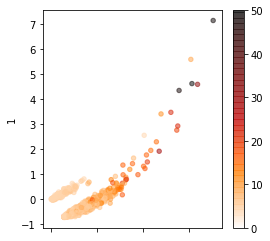

In [19]:
df=pd.DataFrame(cv_doc_topic[0])
df.plot.scatter(x=0,y=1,figsize=(4,4), alpha=0.5,\
               c=love_snippets.n_love_sents+3, cmap=plt.get_cmap('gist_heat_r'),vmin=0);

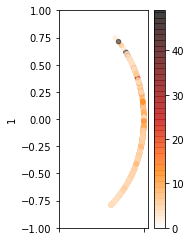

In [20]:
df = unit_norm(pd.DataFrame(cv_doc_topic[0]),demean=False)
df.plot.scatter(x=0,y=1,figsize=(2,4), alpha=0.5,\
               c=love_snippets.n_love_sents+2, cmap=plt.get_cmap('gist_heat_r'),vmin=0)
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")